In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
import pathlib

dataset_url= "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir=tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir=pathlib.Path(data_dir)

228818944/228813984 [==============================] - 2s 0us/step


In [3]:
image_count=len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


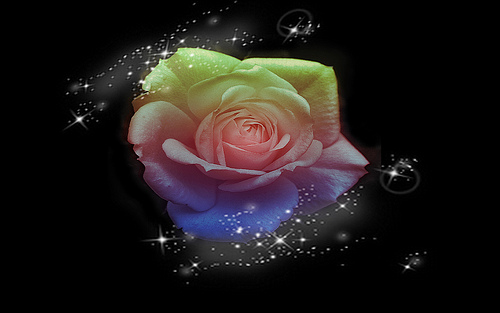

In [6]:
roses=list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[1]))

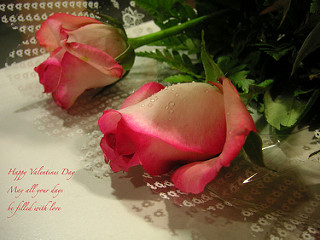

In [7]:
PIL.Image.open(str(roses[2]))

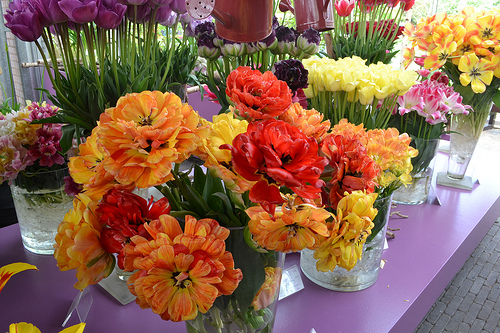

In [8]:
tulips=list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

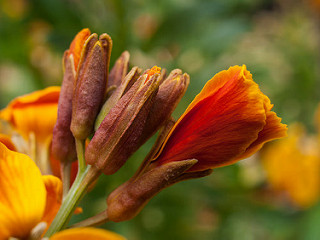

In [9]:
PIL.Image.open(str(tulips[1]))

In [10]:
batch_size=32
img_height=180
img_width=180

In [11]:
train_ds=tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [12]:
val_ds=tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [13]:
class_names=train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


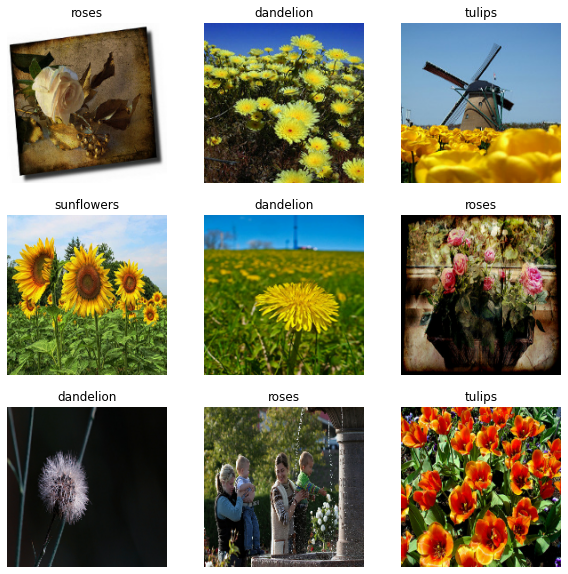

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax=plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [15]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [16]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds=val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [17]:
normalization_layer=layers.experimental.preprocessing.Rescaling(1./255)

In [18]:
normalized_ds=train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch=next(iter(normalized_ds))
first_image=image_batch[0]

print(np.min(first_image), np.max(first_image))

0.0 1.0


In [19]:
num_classes=5

model=Sequential([
                  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
                  layers.Conv2D(16, 3, padding='same', activation='relu'),
                  layers.MaxPooling2D(),
                  layers.Conv2D(32, 3, padding='same', activation='relu' ),
                  layers.MaxPooling2D(),
                  layers.Conv2D(64, 3, padding='same', activation='relu'),
                  layers.MaxPooling2D(),
                  layers.Flatten(),
                  layers.Dense(128, activation='relu'),
                  layers.Dense(num_classes)
])

In [20]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

In [22]:
epochs=10
history=model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)


Epoch 1/10
92/92 [==============================] - 90s 977ms/step - loss: 1.3810 - accuracy: 0.4057 - val_loss: 1.0873 - val_accuracy: 0.5450
Epoch 2/10
92/92 [==============================] - 89s 964ms/step - loss: 0.9964 - accuracy: 0.6093 - val_loss: 1.0205 - val_accuracy: 0.5872
Epoch 3/10
92/92 [==============================] - 92s 1s/step - loss: 0.7971 - accuracy: 0.6972 - val_loss: 0.9268 - val_accuracy: 0.6294
Epoch 4/10
92/92 [==============================] - 89s 966ms/step - loss: 0.5676 - accuracy: 0.7984 - val_loss: 1.0022 - val_accuracy: 0.6335
Epoch 5/10
92/92 [==============================] - 89s 969ms/step - loss: 0.3662 - accuracy: 0.8699 - val_loss: 1.1656 - val_accuracy: 0.6403
Epoch 6/10
92/92 [==============================] - 89s 967ms/step - loss: 0.2182 - accuracy: 0.9281 - val_loss: 1.5440 - val_accuracy: 0.6008
Epoch 7/10
92/92 [==============================] - 89s 968ms/step - loss: 0.1237 - accuracy: 0.9615 - val_loss: 1.5772 - val_accuracy: 0.6226
Ep

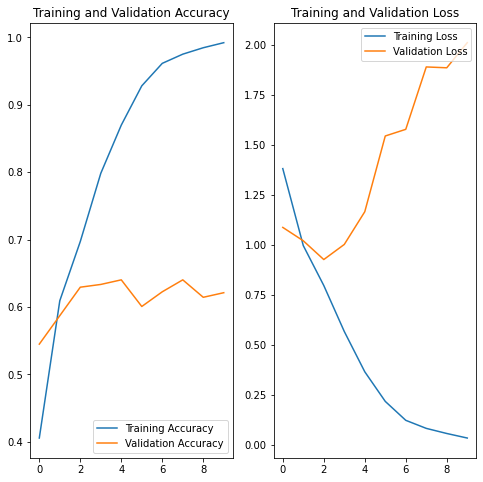

In [25]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range=range(epochs)


plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [26]:
data_augmentation=keras.Sequential(
    [
     layers.experimental.preprocessing.RandomFlip("horizontal",
                                                  input_shape=(img_height,
                                                               img_width,
                                                               3)),
     layers.experimental.preprocessing.RandomRotation(0.1),
     layers.experimental.preprocessing.RandomZoom(0.1),
    ]
)

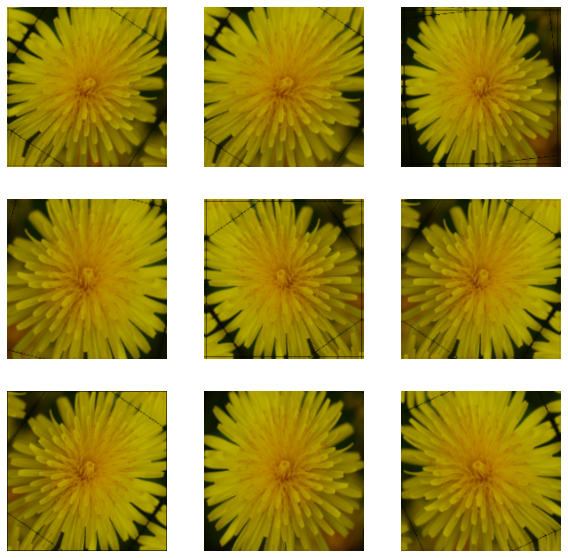

In [30]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax=plt.subplot(3, 3, i+1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [31]:
model=Sequential([
                  data_augmentation,
                  layers.experimental.preprocessing.Rescaling(1./255),
                  layers.Conv2D(16, 3, padding='same', activation='relu'),
                  layers.MaxPooling2D(),
                  layers.Conv2D(32, 3, padding='same', activation='relu'),
                  layers.MaxPooling2D(),
                  layers.Conv2D(64, 3, padding='same', activation='relu'),
                  layers.MaxPooling2D(),
                  layers.Dropout(0.2),
                  layers.Flatten(),
                  layers.Dense(128, activation='relu'),
                  layers.Dense(num_classes)
])

In [32]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [33]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

In [34]:
epochs=15
history=model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)


Epoch 1/15
92/92 [==============================] - 105s 1s/step - loss: 1.3487 - accuracy: 0.4183 - val_loss: 1.1684 - val_accuracy: 0.5150
Epoch 2/15
92/92 [==============================] - 105s 1s/step - loss: 1.0529 - accuracy: 0.5797 - val_loss: 0.9873 - val_accuracy: 0.6240
Epoch 3/15
92/92 [==============================] - 105s 1s/step - loss: 0.9172 - accuracy: 0.6502 - val_loss: 0.9182 - val_accuracy: 0.6431
Epoch 4/15
92/92 [==============================] - 105s 1s/step - loss: 0.8410 - accuracy: 0.6720 - val_loss: 0.8655 - val_accuracy: 0.6689
Epoch 5/15
92/92 [==============================] - 108s 1s/step - loss: 0.8058 - accuracy: 0.6928 - val_loss: 0.8799 - val_accuracy: 0.6839
Epoch 6/15
92/92 [==============================] - 105s 1s/step - loss: 0.7601 - accuracy: 0.7101 - val_loss: 0.8213 - val_accuracy: 0.6894
Epoch 7/15
92/92 [==============================] - 105s 1s/step - loss: 0.7323 - accuracy: 0.7231 - val_loss: 0.7460 - val_accuracy: 0.7153
Epoch 8/15
92

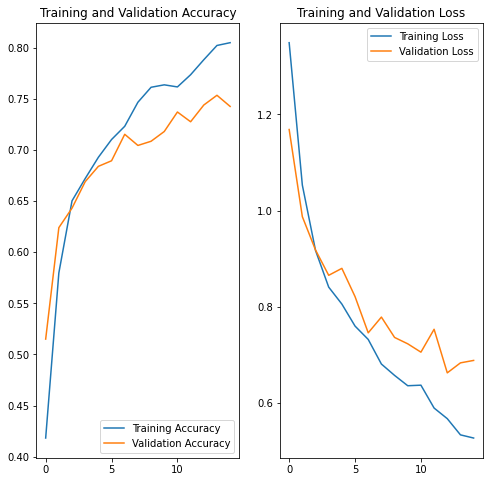

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [37]:
sunflower_url= "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path=tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img=keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array=keras.preprocessing.image.img_to_array(img)
img_array=tf.expand_dims(img_array, 0)

predictions=model.predict(img_array)
score=tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 *np.max(score))
)

This image most likely belongs to sunflowers with a 88.62 percent confidence.
